# <h1><center> Laboratorio di WebScraping </h1>
<h1><center> Anno Accademico 2024-2025 </h1>
<h1><center>  Docente: Laura Ricci </h1>
<h1><center>  Lezione 21 </h1>
<h1><center>  Degree Distribution: Power Law</h1> 
<h1><center>  Il modello di memoria di Pandas</h1> 
<h1><center> 5 Maggio 2025 </h1>

## Modelli di reti: Riassunto

*  esistono diverse reti che sono caratterizzate da
    * small world 
    * high clustering
    * ma in cui esiste anche una grande variabilità nei gradi dei nodi
* la distribuzione dei gradi dei nodi di queste reti segue una **legge di potenze**, o **power law**
* i modelli generativi visti fino ad ora (**Erdos Renyi** e **Watts Strogatz**) non generano reti con queste caratteristiche
* nelle slide successive vedremo
    * cosa è una distribuzione **power law**
    * un nuovo modello, quello di **Barabasi Albert (BA)**, in grado di generare reti con una distribuzione **power law** dei nodi


## Il dataset di Facebook

* utilizziamo il dataset di **Facebook** visto in una lezione precedente e consideriamo solo le **relazioni di amicizia**
* ricordiamo che
    * il grafo delle amicizie è  ricavato da una rete di amicizie più grande
    * sono stati considerati alcuni nodi iniziali e sono state considerate le **ego networks**
    * la rete comprende la ego network di ognuno di questi nodi
        * il nodo, i suoi amici e le relazioni di amicizia tra i suoi amici
    * le ego networks sono state poi combinate
    * il grafo risultante contiene un sottoinsieme di Facebook
* i dati sono memorizzati in un **file di testo** e **non in un file csv** 
  * i valori sono separati da uno spazio bianco: questo tipo di file viene indicato in genere come **edgelist**
  * l'identificatore di ogni nodo è un intero (gli identificatori sono stati parsati per rendere più facile l'elaborazione)
    

## Il file di testo

<center>
<img src="Figures/EdgeList.jpg" style="width:500px;height:300px;"/>

## Il dataset di Facebook

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
pd.read_csv('DataSet/facebook_combined.txt.gz', names=['FriendShipRelation'] )

,FriendShipRelation
0,0 1
1,0 2
2,0 3
3,0 4
4,0 5
...,...
88229,4026 4030
88230,4027 4031
88231,4027 4032
88232,4027 4038


## Il dataset di Facebook: costruzione del grafo

In [2]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    print("shape of data:",array.shape)
    print("datatype of data:",array.dtype)
    G.add_edges_from(array)
    return G

fb= read_graph('DataSet/facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

shape of data: (88234, 2)
datatype of data: int64


(4039, 88234)

## Il dataset di Facebook: grado medio dei nodi

* quale è il grado medio dei nodi?
* considerare che ogni arco incide su due nodi

In [3]:
k = int(round(2*m/n))
k

44

## Il Dataset di Facebook: Coefficente di Clustering 

* il coefficente di clustering può essere calcolato **in modo esatto**

In [4]:
from networkx import average_clustering
C = average_clustering(fb)
C

0.6055467186200862

* ma poichè la computazione è molto oneraosa, si può utilizzare un **algoritmo approssimato** che esegue i calcoli su un **campione**

In [5]:
from networkx.algorithms.approximation import average_clustering
C1 = average_clustering(fb,trials=1000)
C1

0.619

## Il Dataset di Facebook: Lunghezza dei Cammini Approssimata

In [6]:
def sample_path_lengths(G, trials=1000):
    # Scelta random di un insieme di coppie di nodi e calcolo della lunghezza dei cammini tra le coppie
    # trials: numero delle coppie da cui scegliere
    nodes = list(G)
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
                               for pair in pairs]
    return lengths

def estimate_path_length(G, trials=1000):
    return np.mean(sample_path_lengths(G, trials))

L = estimate_path_length(fb)
L

np.float64(3.764)

## Modellare Facebook con WS

In [7]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)
print(C, average_clustering(ws))
print(L, estimate_path_length(ws))

0.6055467186200862 0.622
3.764 3.238


*  si possono osservare valori paragonabili di clustering coefficient e lunghezza media dei cammini rispetto al grafo di Facebook
* conclusione:  **WS** modella bene la caratteristica di **small world** del dataset reale!

## E la distribuzione dei nodi generata da WS?

In [8]:
def degrees(G):
    return [G.degree(u) for u in G]
print(np.mean(degrees(fb)), np.mean(degrees(ws)))
print(np.std(degrees(fb)), np.std(degrees(ws)))

43.69101262688784 44.0
52.41411556737521 1.4309215628189869


* la media dei gradi dei nodi del modello si avvicina molto alla media del grado dei nodi di Facebook
* tuttavia la **varianza è molto diversa**!
    * è molto alta per **Facebook**: alcuni hanno tantissimi amici, altri molto pochi
    * non lo è altrettanto per **WS**

## Distribuzione dei gradi dei nodi: la distribuzione

* fornisce la funzione **Pmf (Probability Mass Function)**
* restituisce una **Pandas Series** che rappresenta la distribuzione di probabilità dei valori in input

In [9]:
from empiricaldist import Pmf
df_1 = Pmf.from_seq([1,2,3,4,5,6])
df_1

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


## Distribuzione dei gradi dei nodi: la distribuzione

In [10]:
from empiricaldist import Pmf
df_2 = Pmf.from_seq([1,2,2,2,5,6])
df_2

,probs
1,0.166667
2,0.500000
5,0.166667
6,0.166667


## Facebook e Watts Strogatz: distribuzione del grado dei nodi

In [11]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist
    
pmf_fb = Pmf.from_seq(degrees(fb))
pmf_fb.mean(), pmf_fb.std()   

(np.float64(43.69101262688785), np.float64(52.41411556737521))

In [12]:
pmf_ws = Pmf.from_seq(degrees(ws))
pmf_ws.mean(), pmf_ws.std()

(np.float64(44.00000000000001), np.float64(1.4309215628189869))

## Facebook e Watts Strogats: plottare la distribuzione

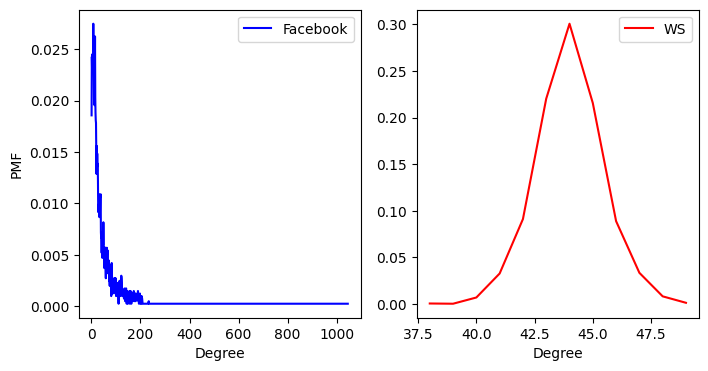

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(pmf_fb,'b',label="Facebook")
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")
plt.subplot(1,2,2)
plt.plot(pmf_ws,'r',label="WS")
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()

## Facebook e Watts Strogats: distribuzione grado dei nodi

* in **WS** la distribuzione dei nodi  è la classica **distribuzione a campana**: la maggior parte dei nodi ha grado **44**
* in  Facebook ci sono molto nodi di utenti con **1 o 2 amici**, ma ci sono anche nodi che hanno **più di 1000 amici**!
    * la distribuzione del grado dei nodi in Facebook è di tipo  **legge di potenza** o **power law**
    * molti nodi di grado basso e pochi nodi con grado alto, e questi hanno gradi tutti diversi tra loro
    * **heavy tail** o **fat tail**: molti valori nella coda della distribuzione

## Power Law 

* è una distribuzione di probabilità definita come segue

<center>
$ y =  C \times k^{-\alpha} $
</center>
 
* $\alpha$ esponente: costante maggiore di 1, comunque positiva
* $C$ fattore di normalizzazione, nel caso di distribuzioni di probabilità normalizza a $1$
* funzione monotona: al crescere di **k**, **y** decresce

## Power Law: distribuzione vendite dei libri

<img src="Figures/LongTailBook.jpg" style="width:900px;height:400px;align=left"/>

## Power Law: fat tail

* **fat tail** 
   * nelle **power law**  le probabilità diminuiscono quando il valore di k aumenta, ma non in modo così drastico come nella 
    distribuzione normale
   * nella distribuzione normale i valori lontani dalla media sono estremamente improbabili. 
   * la coda della legge di potenza contiene molti più valori
       * appare più **grassa**, per questo viene detta **heavy tail**, e si nota soprattutto quando la funzione è rappresentata in scala lineare

## Power Law: scala logaritmica

* una power law è rappresentata come una **linea retta** in **log-log scale**
    * scala logaritmica sia sull'asse delle x che sull'asse delle y

* consideriamo la seguente **power law**
    <center>
    $ p_k = C \times k^{-\alpha} $
    </center>

* calcoliamo il logaritmo sia della parte destra che della parte sinistra 

    <center>
    $ log(p_k) = {-\alpha} \times log(k) +  c  $
    </center>
    in cui $c=log (C)$
* il risultato è una **relazione lineare** con **coefficente lineare negativo** tra **log(k)** e **log(p_k)**
    * il valore di ${\alpha}$ indica l'inclinazione della retta
    * un valore maggiore di ${\alpha}$ corrisponde a una inclinazione più ripida della retta


## Power law ideale in scala logaritmica

<img src="Figures/IdealPowerLaw.jpg" style="width:700px;height:500px;"/>

## Power law ideali ed empiriche

* le power law ricavate da fenomeni reali (ad esempio, le magnitudini dei terremoti, le popolazioni delle città,...) sono 
    * **distribuzioni empiriche**
    * non rappresentate esattamente da una power law ideale
* si utilizza una legge di potenza come **approssimazione della distribuzione reale**
    * il problema è capire esattamente quando questa approssimazione è valida

<img src="Figures/DeviatingPowerLaws.jpg" style="width:900px;height:200px;"/>

## Power law ideali ed empiriche

* altra importante differenza tra una power law teorica e una distribuzione empirica 
    * una funzione  è definita  per un intervallo continuo di numeri reali x 
    * nelle distribuzioni ricavate da dataset reali la funzione è definita, in generale, partendo da **numeri naturali**

<img src="Figures/PowerLawDiscreta.jpg" style="width:700px;height:500px;"/>

## Il "rumore" nella coda della power law

* consideriamo la seguente **power law**

<center>
$ y =  100 \times k^{-2} $
</center>

* **Lotka law**, descrive il numero di paper scientifici pubblicati da un autore, in un particolare campo
* $C=100$, ma in generale  è una costante che dipende dal campo di ricerca specifico
* cosa dice la legge?
    * se ci sono 100 autori con un solo articolo, ce ne saranno 25 con due articoli, 11 con tre, 6 con quattro e così via 
    * ovviamente ci sono delle oscillazioni statistiche, ma
        * per valori piccoli di **k** il valore è molto grande, e quindi la oscillazione è impercettibile
        * per valori grandi di **k** il valore di y è molto piccolo e quindi le oscillazioni **diventano visibili**
        * inoltre lo stesso valore della funzione si può ripetere più volte nella **coda** della funzione
* eliminabile con **tecniche di binding**

## Il "rumore" nella coda della power law

<img src="Figures/Noise.jpg" style="width:700px;height:500px;"/>

## Power Law Distribution 

* le **power law** sono spesso utilizzate per descrivere distribuzioni di probabilità 
* ad esempio, nel nostro caso, vogliamo utilizzarle per descrivere la distribuzione di probabilità dei nodi

<center>
$ Pr(x=k)=  C \times k^{-\alpha} $
</center>

* **k** grado di un nodo
* **Pr(x=k)** probabilità di avere nodi con quel grado
* caratteristiche di queste distribuzioni 
    * nodi con grado basso sono molto più probabili dei nodi di grado alto
        * $\frac{1}{{2}^{\alpha}}$ >> $\frac{1}{{10}^{\alpha}}$
    * la probabilità di avere nodi di grado  $k$ **decresce abbastanza lentamente**     
        * non una decrescita esponenziale

## Power Law distribution: il grafo del web

* grafo orientato
    * nodi del grafo: pagine web, archi del grafo: link tra pagine
* rappresentazione in scala **log log**
* esponente diverso per **in-degree** e **out-degree**

<img src="Figures/PowerLawWeb1.jpg" style="width:600px;height:300px;"/>

## Power Law distribution: il grafo del web

* **coefficente angolare** della retta dell' **in-degree** è minore di quello della retta dell'**out degree**
* **in degree hubs** sono più grandi di **out degree hubs**
    * una pagina web famosa riceve molti links in input, da diverse altre web page create da tante entità diverse
    * avere tanti links in output richiede lo sforzo di una singola entità, l'autore della pagina web

## Power law e reti reali

<center>
<img src="Figures/PowerLawExamples.jpg" style="width:700px;height:400px;"/>

## Power Law  e reti reali: esponenti

<center>
<img src="Figures/PowerLawExponents.jpg" style="width:300px;height:300px;"/>

* notare che tutti gli esponenti sono tali che
$2<\alpha <3$

## Identificare se una rete può essere descritta con una power law

* strategia standard
    * visualizza la distribuzione come un istogramma e disegnarlo in log scale e vedere se si ottine  una retta
    * solo un test preliminare, ma servono osservazioni statistiche più complesse per dedurre che è veramente una power law

## Power Law Distribution e Gradi dei nodi in Reti Reali

<img src="Figures/PowerLawNormal.jpg" style="width:700px;height:500px;"/>

## Distribuzione dei gradi dei nodi di Facebook approssimata con una power law

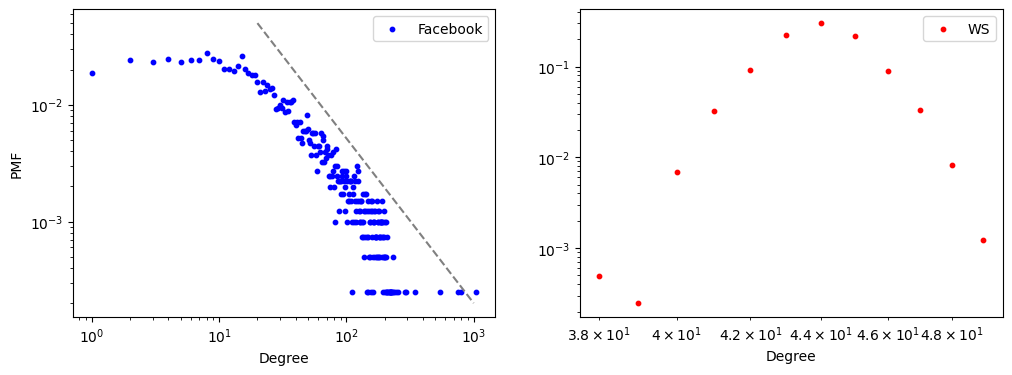

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')
plt.scatter(pmf_fb.index, pmf_fb,color='b',s=10, label="Facebook")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")
plt.subplot(1,2,2)
plt.scatter(pmf_ws.index,pmf_ws,color='r',s=10, label="WS")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()

## Il modello di Barabasi Albert (BA)

* nel 1999 **Barabasi and Albert** proposero un nuovo modello per descrivere la struttura di molte reti reali il cui grado può essere descritto come una **power law**

* elementi essenziali del modello
    * **Growth**: invece considerare un numero fisso di nodi, iniziare con un numero basso di nodi e poi aggiungere vertici incrementalmente
    * **Preferential Attachment**: quando viene creato un nuovo nodo, connetterlo con maggior probabilità ai nodi esistenti che hanno
        un alto grado
* il fenomeno viene anche descritto come **"the rich get richer"**
* le reti generate con questo modello vengono dette **scale free networks**


## Il modello di Barbasi Albert (BA)

* **NetworkX** fornisce una funzione per generare grafi **BA**
* parametri
  * **n**: numero di nodi che il grafo deve avere alla fine del processo incrementale
  * **k**: numero di archi generati per connettere ogni nuovo nodo aggiunto a nodi già esistenti
    * l'aggiunta di ogni nuovo nodo viene fatta secondo la strategia **preferential attachment**

In [15]:
ba = nx.barabasi_albert_graph(4039, 22)

* si aggiunge un nodo e 22 archi a ogni round: 22 è il numero medio di archi per nodo, nel dataset di Facebook

## BA e Facebook a confronto

In [16]:
def degrees(G):
    return [G.degree(u) for u in G]
np.mean(degrees(fb)), np.mean(degrees(ba))

(np.float64(43.69101262688784), np.float64(43.76033671700916))

In [17]:
np.std(degrees(fb)), np.std(degrees(ba))

(np.float64(52.41411556737521), np.float64(40.844095778046494))

In [18]:
pmf_ba = Pmf.from_seq(degrees(ba))
pmf_ba.mean(), pmf_ba.std()

(np.float64(43.76033671700916), np.float64(40.844095778046494))

## BA e Facebook a confronto

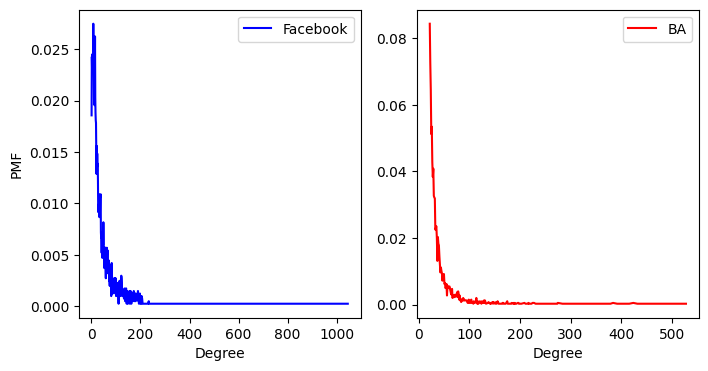

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(pmf_fb,'b',label="Facebook")
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")
plt.subplot(1,2,2)
plt.plot(pmf_ba,'r',label="BA")
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()

## BA e Facebook a confronto

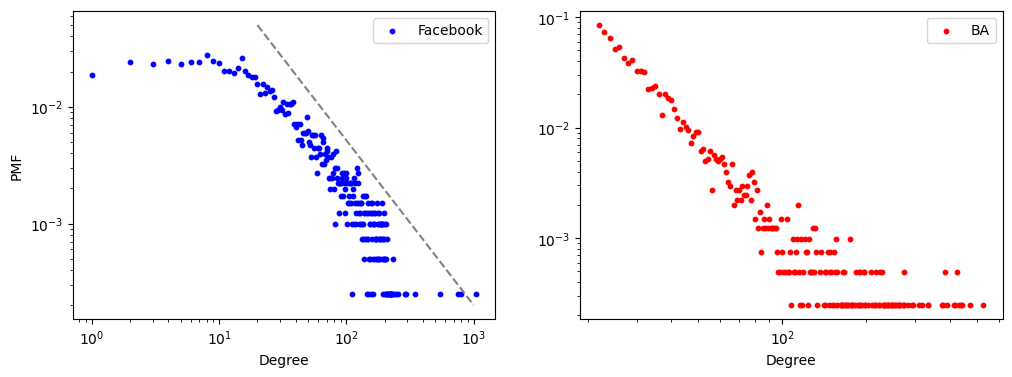

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')
plt.scatter(pmf_fb.index, pmf_fb,color='b',s=10, label="Facebook")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")
plt.subplot(1,2,2)
plt.scatter(pmf_ba.index,pmf_ba,color='r',s=10, label="BA")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()

## Algoritmo per la generazione dei grafi BA

* definiamo una funzione che operi in modo simile alla funzione **NetworkX**
<code>
ba = nx.barabasi_albert_graph(4039, 22)
</code>
* aggiunge incrementalmente nodi alla rete
    * ogni nuovo nodo è connesso a m nodi già esistenti nella rete
    * la probabilità di selezionare un nodo già esistente deve essere proporzionale al grado del nodo
* mantiene una lista **repeated_nodes** in cui ogni nodo compare tante volte quanto è il suo grado
    * in questo modo, scegliendo in modo random unifome dalla lista, i nodi con grado maggiore hanno più probabilità
      di essere selezionati

## Algoritmo per la generazione dei grafi BA

<center>
<img src="Figures/Barabasi.jpg" style="width:500px;height:500px;"/>

## Pandas: il modello di memoria

In [21]:
import pandas as pd
import numpy as np
df = pd.DataFrame({
    'int_1': np.arange(1000000, dtype=int),
    'float_1': np.arange(1000000, dtype=float),
    'int_2': np.arange(10, 1000010, dtype=int),
    'bool_1': np.ones(1000000, dtype=bool),
    'int_3': np.arange(20, 1000020, dtype=int),
    'float_2': np.arange(10, 1000010, dtype=float),
})
df.head(2)

,int_1,float_1,int_2,bool_1,int_3,float_2
0,0,0.0,10,True,20,10.0
1,1,1.0,11,True,21,11.0


## Un DataFrame è mappato in un insieme di array numpy

* **Blocco**: insieme di array che memorizzano un insieme di colonne del **DataFrame** omogenee rispetto al **tipo**
* **BlockManager** un'interfaccia tra i **Dataframe** e i **blocchi**
    * gestione metadati, come i nomi delle colonne ed etichette
    * corrispondenza tra colonne dell'array **numpy** e le colonne del **Dataframe**
    * corrispondenza tra le operazioni sul **Dataframe** e quelle sui vettori

<center>
<img src="Figures/DataFrameNumpy.jpg" style="width:500px;height:400px;"/>

## Come viene memorizzato un DataFrame?

In [22]:
from warnings import filterwarnings
filterwarnings('ignore')
df._data

BlockManager
Items: Index(['int_1', 'float_1', 'int_2', 'bool_1', 'int_3', 'float_2'], dtype='object')
Axis 1: RangeIndex(start=0, stop=1000000, step=1)
NumpyBlock: slice(3, 4, 1), 1 x 1000000, dtype: bool
NumpyBlock: slice(1, 9, 4), 2 x 1000000, dtype: float64
NumpyBlock: slice(0, 6, 2), 3 x 1000000, dtype: int64

In [23]:
df._data.nblocks

3

## Consolidamento dei DataFrame

* cosa accade quando si crea una nuova colonna del **DataFrame**? Due alternative:
    * aggiungere una nuova colonna all’array esistente che contiene le colonne dello stesso tipo
        * occorre copiare i dati, per ridefinire il layout dell'array
    * creare un nuovo array che memorizzi solo la nuova colonna. 
        * minor costo per la creazione del nuovo array
        * maggior costo in termini di prestazioni quando si fanno operazioni sul **DataFrame**
* come vedremo in seguito, questa organizazione ha **forti ripercussioni** sulla gestione del **Dataframe** a livello di programmazione!

## Consolidamento dei DataFrame

* **Pandas** inoltre esegue periodicamente un'operazione di **consolidamanto**

<table>
   <tr>
     <td>
         <img src="Figures/Consolidation1a.jpg" style="width:500px;height:300px;"/>
     <td>
         <img src="Figures/Consolidation2a.jpg" style="width:500px;height:300px;"/>
       </td>
    </tr>

## DataFrame:  copy o view?

* la gestione della memoria vista nelle slide precedenti impatta anche sulle operazioni definite a livello **Pandas** 
* tali operazioni possono
    * creare **una view** del Dataframe su cui operano
    * creare una **copy**

<center>
<img src="Figures/ViewCopy.jpg" style="width:600px;height:300px;"/>

## DataFrame:  copy o view?

* **view**: possibilità di effetti laterali non desiderati nel codice
* **copy**: **bassa efficienza** se si lavora con **DataSet** grandi, è possibile che l'effcienza sia molto bassa

<center>
<img src="Figures/ViewCopy1.jpg" style="width:600px;height:300px;"/>

## Accesso ad una singola colonna: operare su view

In [26]:
import pandas as pd
df = pd.DataFrame({"student_id": [1, 2, 3], "grade": ["A", "C", "D"], "age":['25','28','29']})
df

,student_id,grade,age
0,1,A,25
1,2,C,28
2,3,D,29


In [27]:
grades = df["grade"]
grades.iloc[0] = "E"
df

,student_id,grade,age
0,1,E,25
1,2,C,28
2,3,D,29


## Il warning SettingWithCopyWarning

* è un avviso che **Pandas** può generare quando si effettua un'assegnazione a un DataFrame. 
* questo può accadere quando 
    * si utilizzano assegnazioni concatenate (chained assignment) 
    * quando si lavora con un **DataFrame** ottenuto da uno slice (una porzione) di un altro DataFrame. 
* segnala potenziali problemi nella manipolazione dei dati. 
    * suggerisce che il codice potrebbe non modificare i dati come previsto
    * questo può causare conseguenze indesiderate e bug difficili da individuare e risolvere.

## Accesso a più colonne eterogenee:operare su copie

In [28]:
import pandas as pd
df = pd.DataFrame({"student_id": [1, 2, 3], "grade": ["A", "C", "D"], "age":['25','28','29']})
df

,student_id,grade,age
0,1,A,25
1,2,C,28
2,3,D,29


In [29]:
gradesage = df[["grade","age"]]
gradesage

,grade,age
0,A,25
1,C,28
2,D,29


## Accesso a più colonne eterogenee: operare su copie

In [30]:
from warnings import filterwarnings
filterwarnings('ignore')
gradesage.iloc[0]["age"]=26
gradesage

,grade,age
0,A,26
1,C,28
2,D,29


In [31]:
df

,student_id,grade,age
0,1,A,25
1,2,C,28
2,3,D,29


## PANDAS Copy on Write memory model

* molto difficile prevedere cosa viene restituito da una operazione di **indexing**
    * dipendono dal layout mappato sull'array **numpy** sottostante
    * molti **SettingWithCopyWarning warning**
* soluzione
    * la **versione 2.1** ha introdotto una modalità **Copy-on-Write(CoW)**, che è ancora opzionale e deve essere attivata manualmente del programmatore
    * si prevede che la modalità **CoW** diventerà l'impostazione predefinita nella versione 3.0 di pandas
    * quale versione di PANDAS ho?

In [32]:
import pandas as pd
print(pd.__version__)

2.2.3


## CopyOnWrite (Cow)

* garantisce che ogni **DataFrame** o **Series** derivato da un altro, si comporti sempre come una copia. 
* implementazione
    * copiare il DataFrame e i suoi dati ad ogni operazione, evitando completamente l'uso delle viste (views) in Pandas comporterebbe anche un enorme costo in termini di prestazioni, rendendolo quindi non praticabile.
    * implementato un nuovo meccanismo che assicura che 
        * nessun oggetto venga aggiornato da una singola operazione 
        * i dati non vengano copiati inutilmente.    

## CopyOnWrite (Cow)

In [33]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)
df = pd.DataFrame({"student_id": [1, 2, 3], "grade": ["A", "C", "D"], "age":['25','28','29']})
df

,student_id,grade,age
0,1,A,25
1,2,C,28
2,3,D,29


In [34]:
grades = df["grade"]
grades.iloc[0] = "E"
df

,student_id,grade,age
0,1,A,25
1,2,C,28
2,3,D,29
